# **Time Series Project: Forecasting Amazon Stock Prices**

# **Marks: 30**

Welcome to the project on Time Series. We will use the Amazon Stock Prices dataset for this project.
 
----------------
## **Context:** 
----------------

**Stocks are one of the most popular financial instruments invented for building wealth** and are the **centerpiece of any investment portfolio.** Recent advances in trading technology have opened up stock markets in such a way that nowadays, **nearly anybody can own stocks.** 

In the last few decades, there's been an **explosive increase in the average person's interest in the stock market.** This makes stock value prediction an interesting and popular problem to explore.


------------------
## **Objective:**
------------------

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. We have to **build a time series model** using the AR, MA, ARMA, and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

## **Importing the necessary libraries and overview of the dataset**

**Important Note: Please note that we are downgrading the version of the statsmodels library to version 0.12.1.** Due to some variations, the latest version of the library might not give us the desired results. You can run the below code to downgrade the library and avoid any issues in the output. Once the code runs successfully, either restart the kernel or restart the Jupyter Notebook before importing the statsmodels library. It is enough to run the install statsmodels cell once. To be sure you are using the correct version of the library, you can use the code in the **version check** cell of the notebook.

In [1]:
!pip install statsmodels == 0.12.1

In [2]:
# Version check 

import statsmodels

statsmodels.__version__

'0.12.1'

In [3]:
# Importing libraries for data manipulation
import pandas as pd

import numpy as np

# Importing libraries for visualization
import matplotlib.pylab as plt

import seaborn as sns

# Importing library for date manipulation
from datetime import datetime

# To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

# Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.arima.model import ARIMA

# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### **Loading the dataset**

In [4]:
# If you are having an issue while loading the excel file in pandas, please run the below command in anaconda prompt, otherwise ignore.
# conda install -c anaconda xlrd

In [5]:
df = pd.read_excel('amazon_stocks_prices.xlsx')

df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### **Checking info of the dataset** 

### **Question 1: Check the info of the dataset and write your observations. (2 Marks)**

In [ ]:
# Write your code here

**Observations:_____________**

In [7]:
# Setting date as the index

df = df.set_index(['date'])

df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


Now, let's **visualize the time series** to get an idea about the trend and/or seasonality within the data.

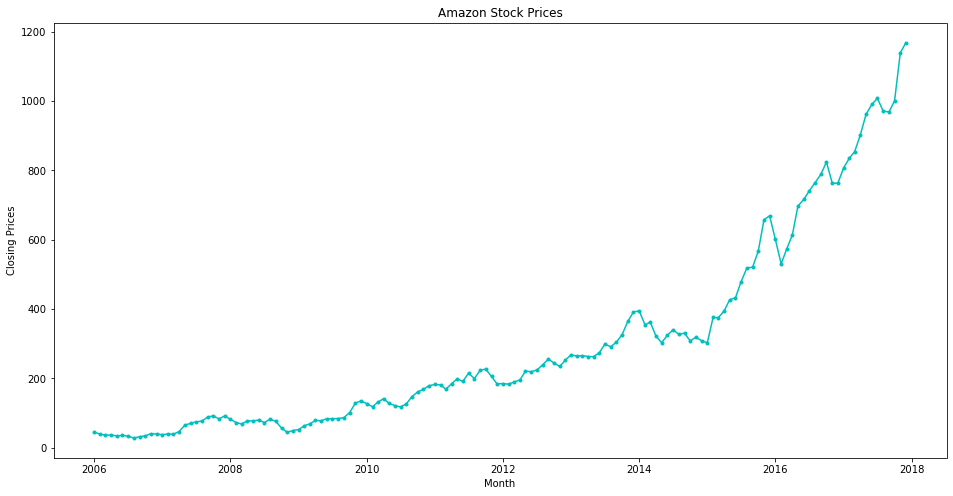

In [8]:
# Visualizing the time series

plt.figure(figsize = (16, 8))

plt.xlabel("Month")

plt.ylabel("Closing Prices")

plt.title('Amazon Stock Prices')

plt.plot(df.index, df.close, color = 'c', marker = '.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test sets.

## **Splitting the dataset**

In [9]:
# Splitting the data into train and test sets

df_train = df.loc['2006-01-01' : '2015-12-01']

df_test = df.loc['2016-01-01' : '2017-12-01']

print(df_train)

print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


Now, let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

## **Testing the stationarity of the series**

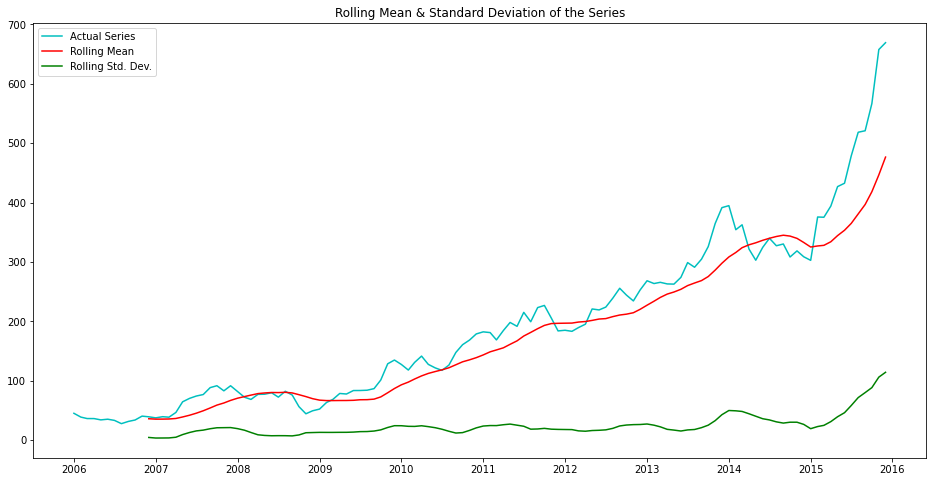

In [10]:
# Calculating the rolling mean and standard deviation for a window of 12 observations

rolmean = df_train.rolling(window = 12).mean() 

rolstd = df_train.rolling(window = 12).std()

# Visualizing the rolling mean and standard deviation

plt.figure(figsize = (16, 8))

actual = plt.plot(df_train, color = 'c', label = 'Actual Series')

rollingmean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean') 

rollingstd = plt.plot(rolstd, color = 'green', label = 'Rolling Std. Dev.')

plt.title('Rolling Mean & Standard Deviation of the Series')

plt.legend()

plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the time series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [11]:
# Define a function to use ADF test

def adfuller(df_train):
    
  # Importing ADF using statsmodels
    from statsmodels.tsa.stattools import adfuller

    print('Dickey-Fuller Test:')

    adftest = adfuller(df_train['close'])

    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])

    for key,value in adftest[4].items():

        adfoutput['Critical Value (%s)'%key] = value

    print(adfoutput)

adfuller(df_train)

Dickey-Fuller Test:
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1, i.e., > 0.05** (for 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

## **Making the series stationary**

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

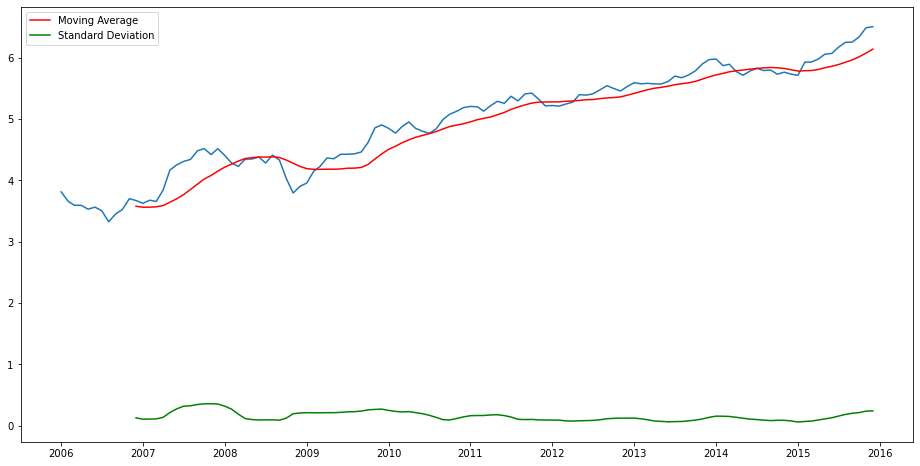

In [12]:
# Visualize the rolling mean and standard deviation after using log transformation

plt.figure(figsize = (16, 8))

df_log = np.log(df_train)

MAvg = df_log.rolling(window = 12).mean()

MStd = df_log.rolling(window = 12).std()

plt.plot(df_log)

plt.plot(MAvg, color = 'r', label = 'Moving Average')

plt.plot(MStd, color = 'g', label = 'Standard Deviation')

plt.legend()

plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has a constant variance.**

**Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

### **Question 2: Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same. (3 Marks)**

In [ ]:
plt.figure(figsize = (16, 8))

df_shift = df_log - df_log.shift(periods = 1)

MAvg_shift = ______________________________   # Use window = 12 

MStd_shift = ______________________________   # Use window = 12

plt.plot(_________ , color = 'c')

plt.plot(__________ , color = 'red', label = 'Moving Average')

plt.plot(__________ , color = 'green', label = 'Standard Deviation')

plt.legend()

plt.show()

# Dropping the null values that we get after applying differencing method

df_shift = df_shift.dropna()

**Observation:___________________** 

Let us use the adfuller test to check the stationarity.

In [14]:
adfuller(df_shift)

Dickey-Fuller Test:
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


**Observation:**
- We can see that **the p-value is now far lesser than 0.05** (for 95% confidence interval), **therefore we can reject the null hypothesis that the series is non-stationary.**

We can conclude that **the series is now stationary.** Let's decompose the time series to check its different components.

## **Decomposing the time series components into Trend, Seasonality, and Residual**

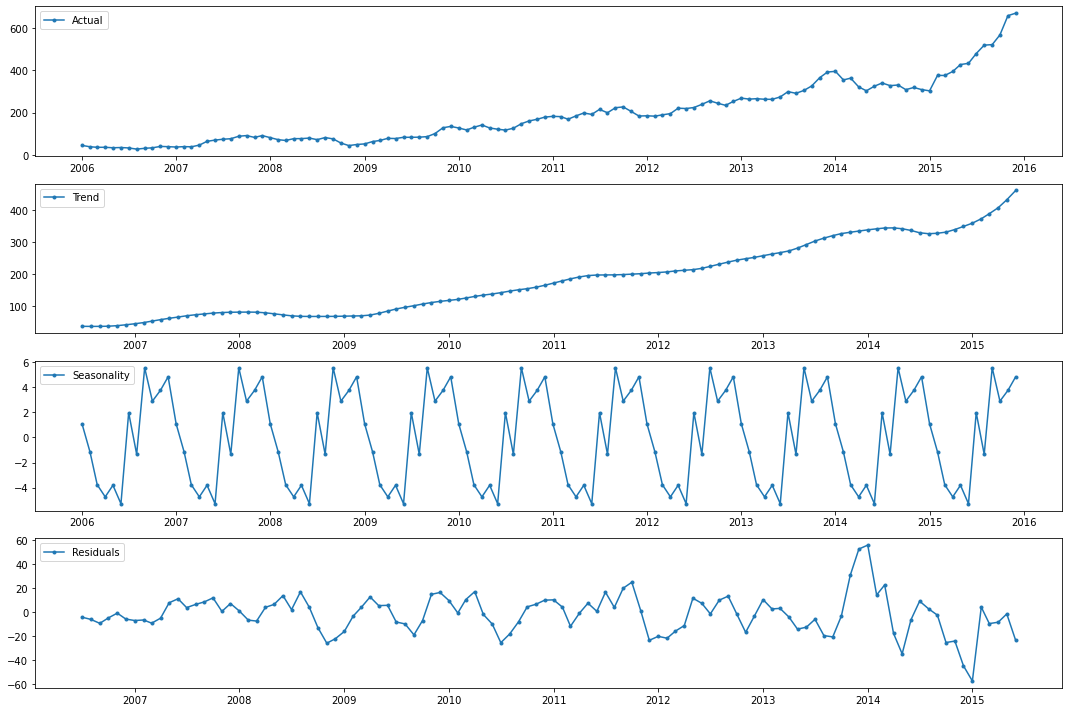

In [15]:
# Importing the seasonal_decompose function to decompose the time series

from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df_train)

# Extracting the trend component
trend = decomp.trend

# Extracting the seasonal component
seasonal = decomp.seasonal

# Extracting the residuals
residual = decomp.resid

plt.figure(figsize = (15, 10))

plt.subplot(411)
plt.plot(df_train, label = 'Actual', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(412)
plt.plot(trend, label = 'Trend', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(414)
plt.plot(residual, label = 'Residuals', marker = '.')
plt.legend(loc = 'upper left')

plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality, and residuals components** in the series.
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Now, let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q, i.e., order of AR and MA models to be used.**

## **ACF and PACF plots**

**Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models.**

<Figure size 1152x576 with 0 Axes>

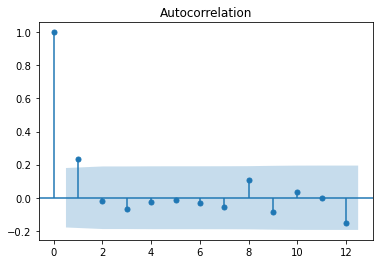

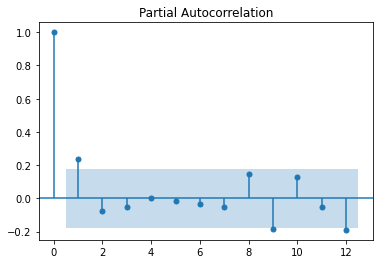

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16, 8))

plot_acf(df_shift, lags = 12) 

plt.show() 

plot_pacf(df_shift, lags = 12) 

plt.show()

**Observations:**
- From the above PACF plot, we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p = 1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q = 1.**

## **AR Model**

### **Question 3: Fit and predict the shifted series with the AR model and calculate the RMSE. Also, visualize the time series and write your observations. (5 Marks)**

In [ ]:
# Importing AutoReg function to apply AR model

from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (16, 8))

model_AR = _______________ # Use number of lags as 1 and apply AutoReg function on df_shift series

results_AR = ________________ # Fit the model

plt.plot(df_shift)

predict = results_AR.predict(start = 0, end = len(df_shift) - 1) # Predict the series 

predict = predict.fillna(0) # Converting NaN values to 0

plt.plot(___________ , color = 'red')

plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict, df_shift['close'], squared = False))  # Calculating rmse

plt.show()

**Observations:________________________**

**Let's check the AIC value** of the model

In [ ]:
results_AR.aic

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model.

## **MA Model**

**We will be using an ARIMA model with p = 0 and d = 0 so that it will work as an MA model.**

### **Question 4: Fit and predict the shifted series with the MA model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize = (16, 8))

model_MA = _________________ # Using p = 0, d = 0, q = 1 and apply ARIMA function on df_shift series

results_MA = _____________ # Fit the model

plt.plot(df_shift)

plt.plot(results_MA.fittedvalues, color = 'red')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues, df_shift['close'], squared = False))

plt.show()

**Observations:_______**

**Let's check the AIC value** of the model

In [ ]:
results_MA.aic

- **The MA model is giving a much lower AIC** in comparison to the AR model, implying that **the MA model fits the training data better.** 

## **ARMA Model**

We will be using an **ARIMA model with p = 1 and q = 1** (as observed from the ACF and PACF plots) **and d = 0 so that it will work as an ARMA model.**

### **Question 5: Fit and predict the shifted series with the ARMA model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

In [ ]:
plt.figure(figsize = (16, 8))

model_ARMA = _______________ # Using p = 1, d = 0, q = 1 and apply ARIMA function on df_shift series

results_ARMA = _______________ # Fit the model

plt.plot(df_shift)

plt.plot(results_ARMA.fittedvalues, color = 'red')

plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, df_shift['close'], squared = False))

plt.show()

**Observations:________________________**

**Let's check the AIC value** of the model

In [ ]:
results_ARMA.aic

- **The AIC value of the ARMA model is more or less similar** to the MA model.

**Let us try using the ARIMA Model.**

## **ARIMA Model**

Here, we will be using an **ARIMA Model with p = 1, d = 1, & q = 1**.

### **Question 6: Fit and predict the shifted series with the ARIMA model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

Since we are using d=1 in the ARIMA model, it will result in double differencing of the df_log series. So, we need double shifted series in order to calculate the RMSE of the model.

In [23]:
# Getting double differenced series

df_shift2 = df_log - df_log.shift(periods = 2)

df_shift2.dropna(inplace=True)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize = (16, 8))

model_ARIMA = ________________ # Using p = 1, d = 1, q = 1 and apply ARIMA function on df_shift series

results_ARIMA = ___________________ # Fit the model

plt.plot(df_shift)

plt.plot(results_ARIMA.fittedvalues, color = 'red')

plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues, df_shift2['close'], squared = False))

plt.show()

**Observations:________**

**Let's check the AIC value** of the model

In [ ]:
results_ARIMA.aic

- **The AIC value of the ARIMA model is higher than the ARMA model**. 

We observed that **MA and ARMA models return almost the same RMSE.** Also, there is not much difference in the AIC value of both the models.

**We can choose to predict the values using the ARMA model as it takes into account more factors than the MA model.**

In [26]:
# Printing the fitted values
predictions = pd.Series(results_ARMA.fittedvalues)

predictions

date
2006-02-01    0.022231
2006-03-01   -0.019675
2006-04-01    0.009178
2006-05-01    0.018981
2006-06-01    0.001609
                ...   
2015-08-01    0.043233
2015-09-01    0.032285
2015-10-01    0.015692
2015-11-01    0.039275
2015-12-01    0.050568
Length: 119, dtype: float64

## **Inverse Transformation**

Now we have fitted values using the ARMA model, **we will use the inverse transformation to get back the original values.**

### **Question 7: Apply an inverse transformation on the predictions of the ARMA Model. (5 Marks)**

In [ ]:
# First step - doing a cumulative sum

predictions_cumsum = _______________ # Use .cumsum fuction on the predictions

predictions_cumsum

In [ ]:
# Second step - adding the first value of the log series to the cumulative sum values

predictions_log = pd.Series(df_log['close'].iloc[0], index = df_log.index)

predictions_log = predictions_log.add(predictions_cumsum, fill_value = 0)

predictions_log

In [ ]:
# Third step - applying exponential transformation

predictions_ARMA = _________________ # Use exponential function on predictions_log

predictions_ARMA

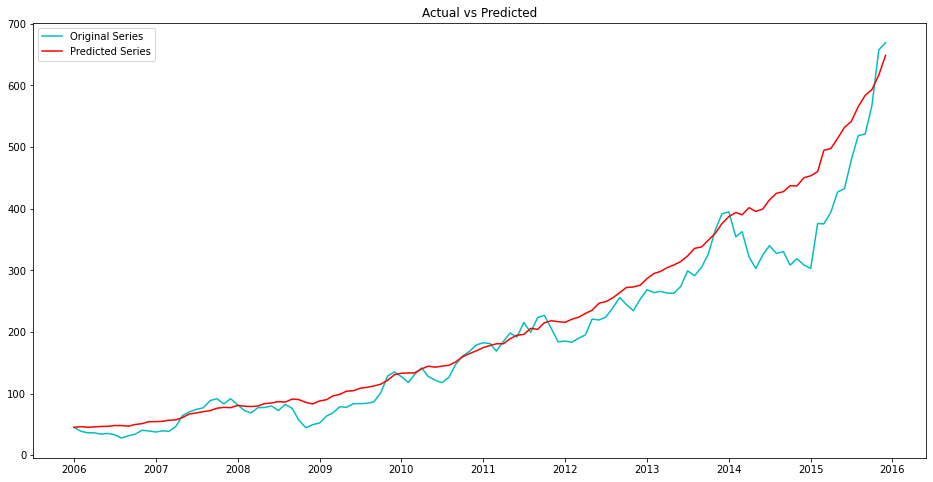

In [30]:
# Plotting the original vs predicted series

plt.figure(figsize = (16, 8))

plt.plot(df_train, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series**, i.e., The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

## **Forecasting the values for next 24 months and compare it with test data**

**To forecast the values for the next 24 months using the ARMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

### **Question 8: Forecast the stocks prices for the next 24 months and perform the inverse transformation. (5 Marks)**

In [ ]:
# Forecasting the values for next 24 months

forecasted_ARMA = _____________________ # Forecast using results_ARMA for next 24 months. Keep steps = 24

forecasted_ARMA

In [32]:
# First step - doing cumulative sum

forecasted_ARMA_cumsum = forecasted_ARMA.cumsum()

forecasted_ARMA_cumsum

2016-01-01    0.014983
2016-02-01    0.036928
2016-03-01    0.059147
2016-04-01    0.081378
2016-05-01    0.103608
2016-06-01    0.125839
2016-07-01    0.148070
2016-08-01    0.170301
2016-09-01    0.192532
2016-10-01    0.214763
2016-11-01    0.236993
2016-12-01    0.259224
2017-01-01    0.281455
2017-02-01    0.303686
2017-03-01    0.325917
2017-04-01    0.348147
2017-05-01    0.370378
2017-06-01    0.392609
2017-07-01    0.414840
2017-08-01    0.437071
2017-09-01    0.459302
2017-10-01    0.481532
2017-11-01    0.503763
2017-12-01    0.525994
Freq: MS, Name: predicted_mean, dtype: float64

In [33]:
# Second step - adding the last value of the log series to the cumulative sum values

index = pd.date_range('2016-01-1','2018-1-1', freq = '1M') - pd.offsets.MonthBegin(1)

forecasted_log = pd.Series(df_log['close'].iloc[-1], index = index)

forecasted_log = forecasted_log.add(forecasted_ARMA_cumsum, fill_value = 0)

forecasted_log

2016-01-01    6.521156
2016-02-01    6.543100
2016-03-01    6.565320
2016-04-01    6.587550
2016-05-01    6.609781
2016-06-01    6.632012
2016-07-01    6.654243
2016-08-01    6.676473
2016-09-01    6.698704
2016-10-01    6.720935
2016-11-01    6.743166
2016-12-01    6.765397
2017-01-01    6.787628
2017-02-01    6.809858
2017-03-01    6.832089
2017-04-01    6.854320
2017-05-01    6.876551
2017-06-01    6.898782
2017-07-01    6.921013
2017-08-01    6.943243
2017-09-01    6.965474
2017-10-01    6.987705
2017-11-01    7.009936
2017-12-01    7.032167
dtype: float64

In [34]:
# Applying exponential transformation to the forecasted log values

forecasted_ARMA = _________________ # Use exponential function on forecasted_log

forecasted_ARMA

2016-01-01     679.363323
2016-02-01     694.436236
2016-03-01     710.038959
2016-04-01     726.000147
2016-05-01     742.320450
2016-06-01     759.007643
2016-07-01     776.069961
2016-08-01     793.515835
2016-09-01     811.353889
2016-10-01     829.592938
2016-11-01     848.241997
2016-12-01     867.310282
2017-01-01     886.807219
2017-02-01     906.742441
2017-03-01     927.125803
2017-04-01     947.967379
2017-05-01     969.277468
2017-06-01     991.066603
2017-07-01    1013.345553
2017-08-01    1036.125328
2017-09-01    1059.417188
2017-10-01    1083.232643
2017-11-01    1107.583464
2017-12-01    1132.481686
dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

In [ ]:
# Plotting the original vs predicted series

plt.figure(figsize = (16, 8))

plt.plot(df, color = 'c', label = 'Original Series')

plt.plot(___________, color = 'r', label = 'Prediction on Train data') # Plot the predictions_ARMA series

plt.plot(___________, label = 'Prediction on Test data', color = 'b')  # Plot the forecasted_ARMA series

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in 2015.
- **On the test data, the model can correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue), and they both have an upward trend. **However, the test predictions are not able to identify the volatile variations in the stock prices over the last two years.**


Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

### **Question 9: Check the RMSE on the original train and test data and write your conclusion from the above analysis. (4 Marks)**

In [ ]:
from sklearn.metrics import mean_squared_error

error = ____________________________ # Calculate RMSE using the predictions_ARMA and df_train

error

In [ ]:
from sklearn.metrics import mean_squared_error

error = _________________________  # Calculate RMSE using the forecasted_ARMA and df_test

error

## **Conclusion:**

**Write your conclusion here.**